In [9]:
import os
import re
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

In [10]:
__path__ = os.getcwd()

In [11]:
mct1_manifest = os.path.join(__path__, "mct1-graph-manifest.txt")
mct1_manifest_files = open(mct1_manifest, "r").read().split('\n')

In [12]:
mct1_results = os.path.join(__path__, "mct1_output")
mct1_result_files = next(os.walk(mct1_results), (None, None, []))[2]

In [13]:
results = {}
for f in mct1_result_files:
    results[f] = pd.read_csv(os.path.join(mct1_results, f), sep="\t")

In [28]:
_d = {}
for p in [
        "avg_noCollapse",
        "mod_noCollapse",
        "avg_collapse",
        "mod_collapse"
    ]:
        pattern =   p
        _d[pattern] = {
            "rep0": {}, 
            "rep1": {}, 
            "rep2": {}, 
            "rep3": {}
        }
        
for x in mct1_manifest_files:
    try:
        percent1 =   str(re.search('metabolomics_dropout(.*)percent_mct1_12hr_proteomics', x)[1])
        percent2 =   str(re.search('proteomics_dropout(.*)percent', x)[1])
    except:
        continue
    replicate = "rep" + re.search('percent_rep(.*).mvrs', x)[1]
    for p in [
        "avg_noCollapse",
        "mod_noCollapse",
        "avg_collapse",
        "mod_collapse"
    ]:
        pattern =   p
        try:
            this_file = 'mct1_12hr_metabolomics_dropout{0}percent_mct1_12hr_proteomics_dropout{1}percent_{2}_{3}.csv'.format(
                percent1, 
                percent2, 
                replicate, 
                pattern)
            this_df = results[this_file]
            _d[pattern][replicate][str(percent1)+"% / "+str(percent2)+"%"] = this_df[this_df.columns[2]].unique().size
        except:
            _d[pattern][replicate][str(percent1)+"% / "+str(percent2)+"%"] = np.nan
    
compiled_data = {}
for k in _d.keys():       
    data = pd.DataFrame(_d[k])
    data = data.dropna()
    compiled_data[k] = data

Text(0.06, 0.5, '# of Reaction Patterns')

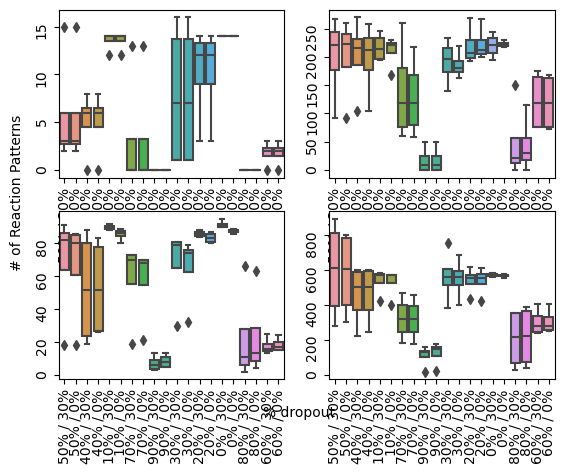

In [30]:
fig, axes = plt.subplots(2, 2, sharex=False, sharey=False)
x_count = 0
y_count = 0
counter = 0
for c in compiled_data:
    sns.boxplot(compiled_data[c].T, ax=axes[x_count, y_count])
    axes[x_count, y_count].tick_params(labelrotation=90)
    counter += 1
    if x_count == 0:
        x_count = 1
    else:
        x_count = 0
    if counter % 2 == 0:
        y_count += 1
        
fig.text(0.5, 0.04, '% dropout', ha='center', va='center')
fig.text(0.06, 0.5, '# of Reaction Patterns', ha='center', va='center', rotation='vertical')